In [2]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## For mean 

In [2]:
versions = [2.03, 2.04, 2.05, 2.07, 2.08]
results = []
for version in versions:
    with open(f"../results/alignment_tax_v{str(version)}.json", "r") as f:
        results.append(json.load(f))

[print(r["meta"]["note"]) for r in results]

redo test with fix for NaN
subtracting code, adding text, subtracting all
subtracting code
subtracting random acts
adding only text


[None, None, None, None, None]

In [3]:
def get_scores(results):
    metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
    modes = ("only_text", "only_code")
    injection_coefficients = list(results["only_code"].keys())

    scores = {}
    for mode in modes:
        scores[mode] = {}
        for metric in metrics:
            scores[mode][metric] = {"avg": [], "rel": []}
            for ic in injection_coefficients:
                if metric in ("top1_acc", "top10_acc"):
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            results[mode][ic][metric],
                            weights=results[mode][ic]["total_encoded_tokens"],
                        )
                    )
                else:
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            results[mode][ic][metric],
                            weights=results[mode][ic]["total_tokens_with_skip"],
                        )
                    )
            avg_scores = scores[mode][metric]["avg"]
            scores[mode][metric]["rel"] = [i / avg_scores[0] * 100 for i in avg_scores]
    return scores

In [6]:
scores = [get_scores(res) for res in results] 

labels = [
    "Subtract code & add text",
    "Subtract code & add all and text",
    "Subtract code", 
    "subtract random",
    "Add text", 
]

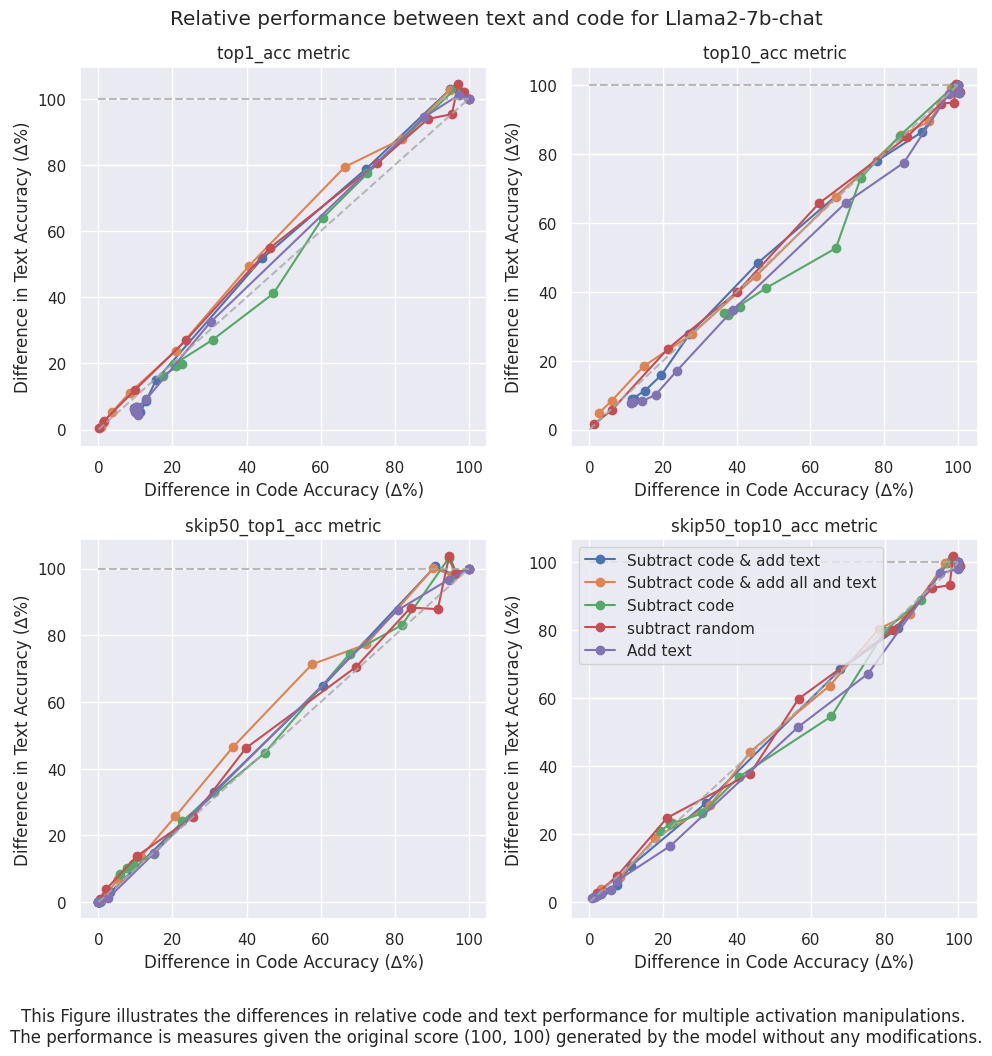

In [10]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")

for metric, ax in zip(metrics, axs.reshape(-1)):
    for label, score in zip(labels, scores):
        ax.plot(score["only_code"][metric]["rel"], score['only_text'][metric]["rel"], marker="o", label=label)

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Difference in Code Accuracy (∆%)")
    ax.set_ylabel("Difference in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0, scale], color="darkgray", linestyle="--", alpha=0.8)

plt.legend()
title = "Relative performance between text and code for Llama2-7b-chat"
txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
The performance is measures given the original score (100, 100) generated by the model without any modifications."""
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

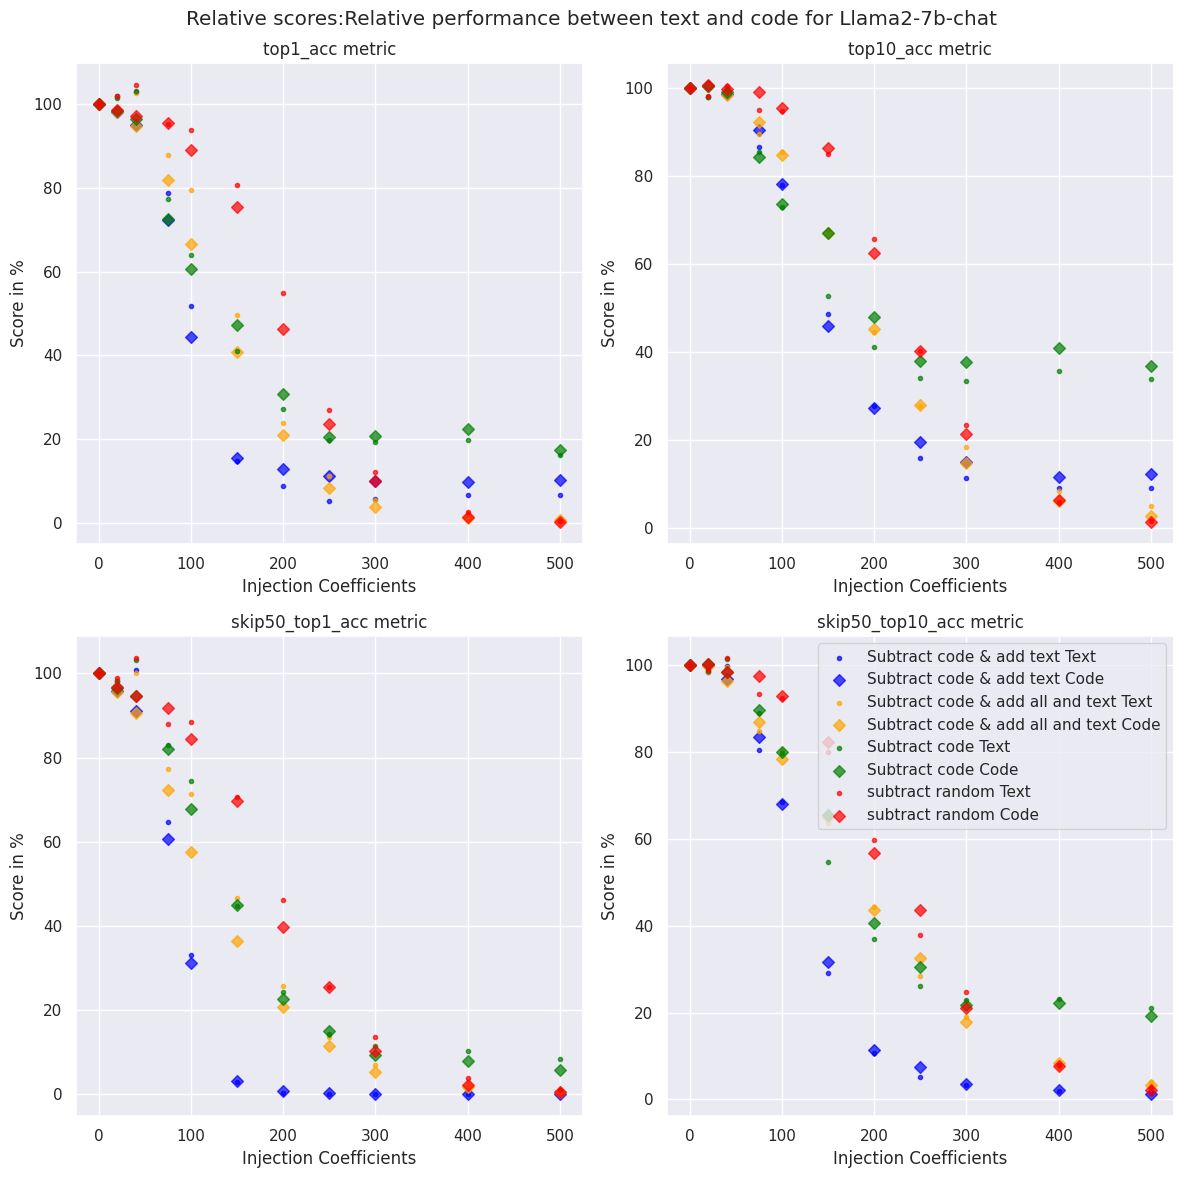

In [11]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # , sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["rel"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["rel"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show()

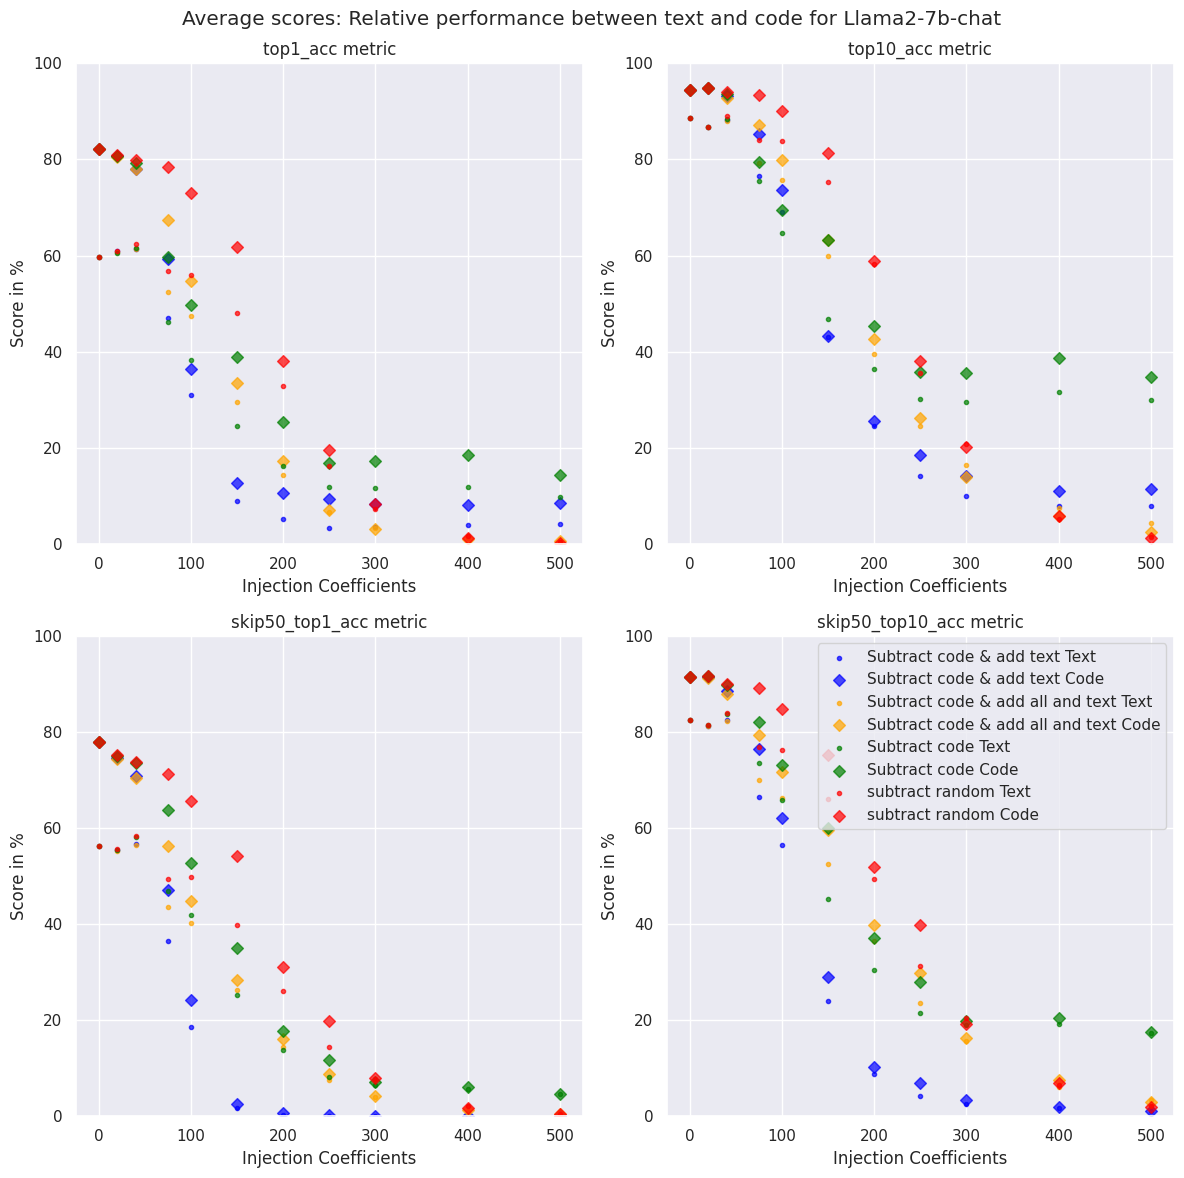

In [12]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["avg"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["avg"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Average scores: " + title)
fig.tight_layout()
plt.show()

## For PCA

In [3]:
#NOTE: omitting random
# versions = [2.08, 2.09, 2.11, 2.12]
versions = [2.13]
results = []
for version in versions:
    with open(f"../results/alignment_tax_v{str(version)}.json", "r") as f:
        results.append(json.load(f))

#NOTE: notes are wrong
[print(r["meta"]["note"]) for r in results]

PCA subtract code and all, add text


[None]

In [4]:
def get_scores(results):
    metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
    modes = ("only_text", "only_code")
    injection_coefficients = list(results["only_code"].keys())

    scores = {}
    for mode in modes:
        scores[mode] = {}
        for metric in metrics:
            scores[mode][metric] = {"avg": [], "rel": []}
            for ic in injection_coefficients:
                if metric in ("top1_acc", "top10_acc"):
                    scores[mode][metric]["avg"].append(100*np.average(results[mode][ic][metric], weights=results[mode][ic]["total_encoded_tokens"]))
                else:
                    scores[mode][metric]["avg"].append(100*np.average(results[mode][ic][metric], weights=results[mode][ic]["total_tokens_with_skip"]))
            avg_scores = scores[mode][metric]["avg"]
            scores[mode][metric]["rel"] = [i/avg_scores[0]*100 for i in avg_scores]
    return scores

In [9]:
scores = [get_scores(res) for res in results] 

labels = [
    "Subtract code & all, add text",
]

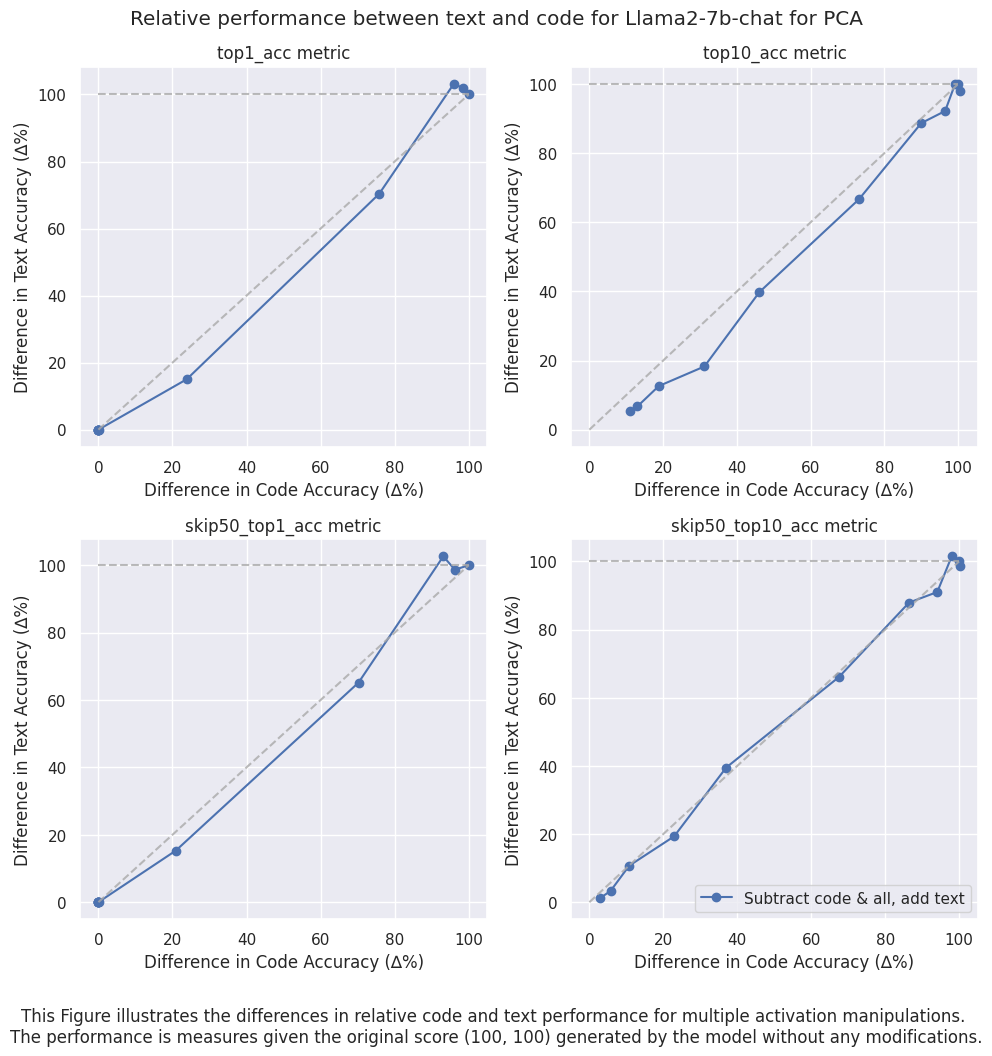

In [10]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")

for metric, ax in zip(metrics, axs.reshape(-1)):
    for label, score in zip(labels, scores):
        ax.plot(score["only_code"][metric]["rel"], score['only_text'][metric]["rel"], marker="o", label=label)

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Difference in Code Accuracy (∆%)")
    ax.set_ylabel("Difference in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

plt.legend()
title = "Relative performance between text and code for Llama2-7b-chat for PCA"
txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
The performance is measures given the original score (100, 100) generated by the model without any modifications."""
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

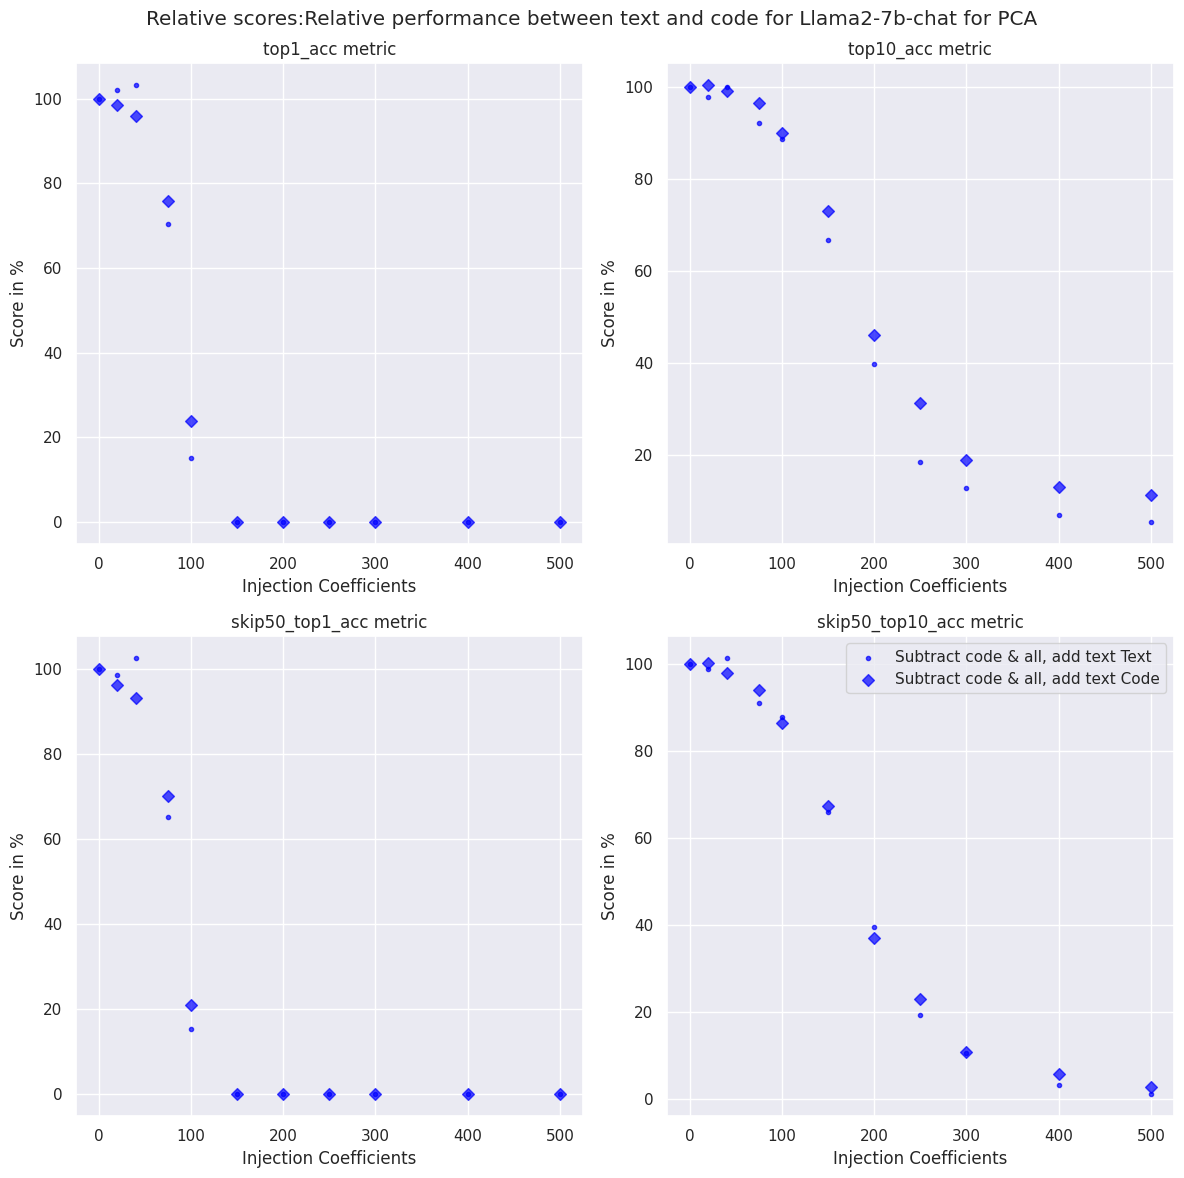

In [11]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["rel"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["rel"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show()

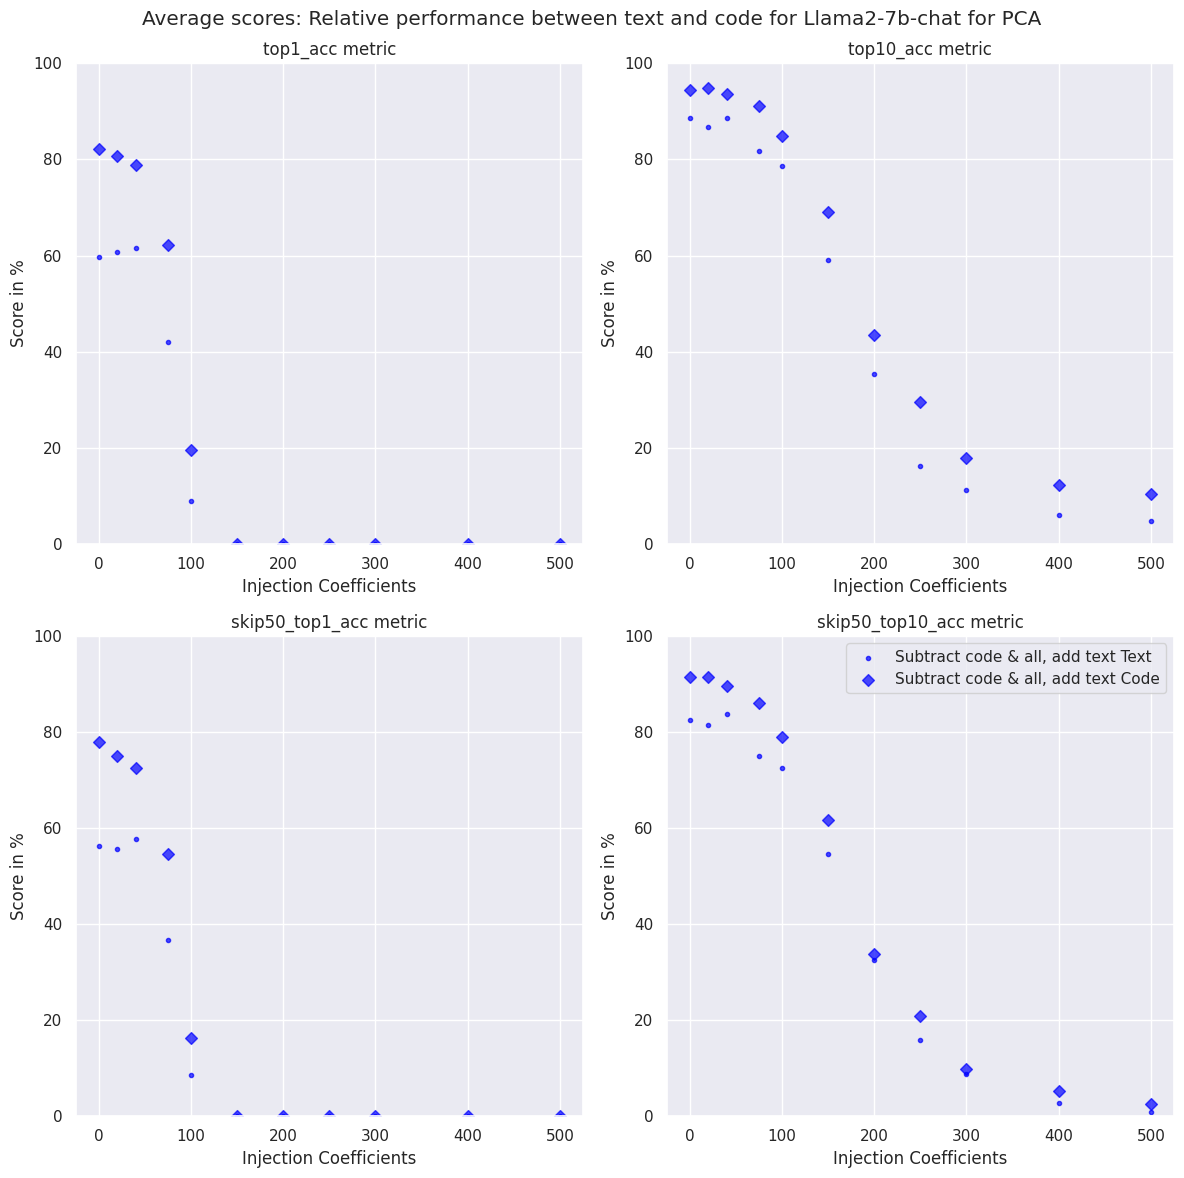

In [12]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["avg"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["avg"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")
    
plt.legend()
plt.suptitle("Average scores: " + title)
fig.tight_layout()
plt.show()